# Piano per lo svolgimento

1) Scegliere se discretizzare e normalizzare prima o dopo la suddivisione in time series mensili. L'importante è che la codifica dei bins sia la stessa per tutte le time series

2) Se decidiamo di effettuare una discretizzazione "statica", allora è consigliato rimuovere i linear trend dalle series

3) Riguardo alla rimozione del noise, valutare sperimentalmente cosa succede con o senza di essa

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline
from pylab import rcParams
rcParams['figure.figsize'] = 16,4
rcParams["font.size"] = 14

Populating the interactive namespace from numpy and matplotlib


## Dataset: IBM stock values from 1962 to 2018

In [3]:
series = pd.Series.from_csv('ibm_daily_1962-2018.csv', sep=',',header=0)

/usr/local/lib/python2.7/dist-packages/pandas/core/series.py:3724: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


## Time series da cui partire
Due casi: con noise e senza noise

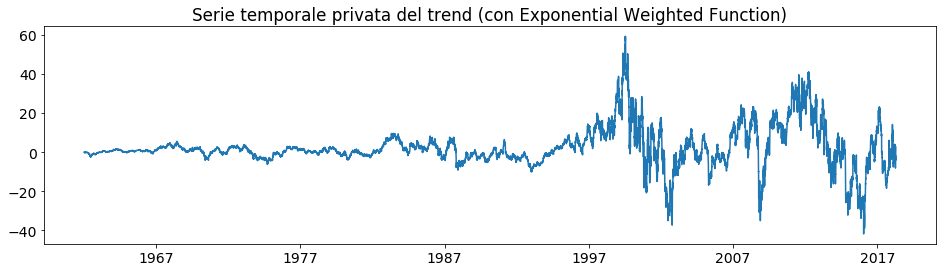

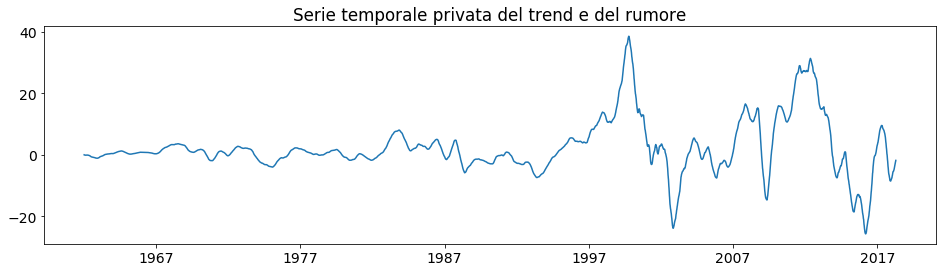

In [4]:
# linear_trend = series.rolling(window=2000, min_periods=1).mean()
# untrended = series - linear_trend
# series_untr = pd.Series(untrended, series.index)
# plt.plot(series_untr)
# plt.figure()
# untr_no_noise = series_untr.rolling(window=200, min_periods=1).mean()
# plt.plot(untr_no_noise)

plt.figure()
exp_decay_series = pd.Series(series - series.ewm(halflife=150).mean(), series.index)
plt.title('Serie temporale privata del trend (con Exponential Weighted Function)')
plt.plot(exp_decay_series)

plt.figure()
decay_no_noise = exp_decay_series.rolling(window=150, min_periods=1).mean()
plt.title('Serie temporale privata del trend e del rumore')
plt.plot(decay_no_noise)

In [84]:
# sns.kdeplot(decay_no_noise, cut=0, shade=True)

## Qualche esperimento per visualizzare le singole serie mensili

Date
1962-01-02    400
1962-01-03    399
1962-01-04    400
1962-01-05    399
1962-01-08    399
1962-01-09    399
1962-01-10    398
1962-01-11    398
1962-01-12    399
1962-01-15    399
1962-01-16    399
1962-01-17    399
1962-01-18    399
1962-01-19    399
1962-01-22    398
1962-01-23    398
1962-01-24    398
1962-01-25    398
1962-01-26    398
1962-01-29    398
1962-01-30    398
1962-01-31    398
1962-02-01    398
1962-02-02    398
1962-02-05    398
1962-02-06    398
1962-02-07    398
1962-02-08    398
1962-02-09    398
1962-02-12    398
             ... 
2018-03-02    327
2018-03-05    328
2018-03-06    330
2018-03-07    331
2018-03-08    333
2018-03-09    335
2018-03-12    337
2018-03-13    339
2018-03-14    341
2018-03-15    343
2018-03-16    345
2018-03-19    347
2018-03-20    349
2018-03-21    350
2018-03-22    352
2018-03-23    353
2018-03-26    355
2018-03-27    356
2018-03-28    358
2018-03-29    359
2018-04-02    360
2018-04-03    361
2018-04-04    362
2018-04-05    363
2018-

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  del sys.path[0]


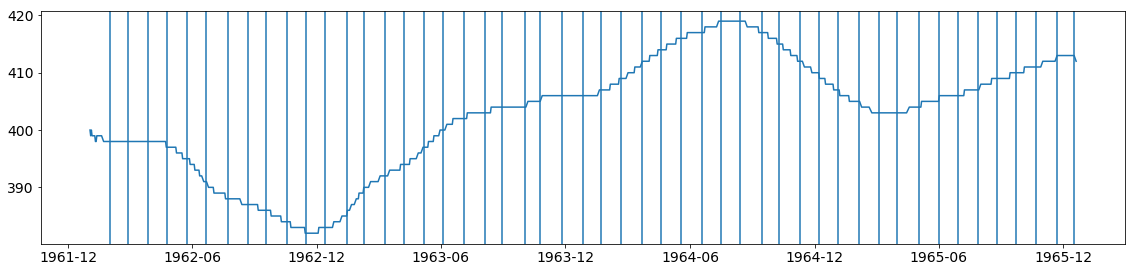

In [12]:
from pandas import TimeGrouper
from pandas import DataFrame

all_discretized_vals, bins = pd.cut(decay_no_noise, 1000, labels=False, retbins=True)

from_index, to_index = 0,1000
plt.plot(all_discretized_vals[from_index:to_index])

# for b in bins:
#     plt.plot(decay_no_noise.index, np.ones(len(decay_no_noise.index)) * b)


offsets = [len(gr)-1 for name, gr in decay_no_noise.groupby(TimeGrouper('M'))]
cumulative_offsets = np.cumsum(offsets)
for o in cumulative_offsets:
    if o >= from_index and o <= to_index:
        plt.axvline(x=decay_no_noise.index[o])
#plt.axvline(x=decay_no_noise.index[0])
#plt.axvline(x=decay_no_noise.index[len(decay_no_noise.index) - 1])
plt.tight_layout()

## Suddivisione in time series mensili (676 serie), discretizzazione e normalizzazione

In [19]:
from pandas import TimeGrouper
from pandas import DataFrame
import collections

#--------------------------------------------------------------------------------------------------------------
#                      Normalizzazione dei valori e discretizzazione, 
#                          poi suddivisione in 676 serie mensili
#--------------------------------------------------------------------------------------------------------------

all_discretized_vals = pd.cut(series_untr, 8, labels=False)
discretized_original = pd.Series(all_discretized_vals, series.index)


discretized_groups = discretized_original.groupby(TimeGrouper('M'))

mm = collections.OrderedDict()
for name, group in discretized_groups:    
    mm["%s-%s" % (name.year,name.month)] = group.values


#--------------------------------------------------------------------------------------------------------------
#                          Scrittura del file nel formato SPMF descritto in
#                    http://www.philippe-fournier-viger.com/spmf/HirateYamana.php
#--------------------------------------------------------------------------------------------------------------

mhanz = open("progetto_DM_seq_mensili_discretizzate.txt", "w")

for k in mm.keys():
    vals = mm[k]
    contatore_tempo = 0
    for v in vals:
        mhanz.write('<%s> %s -1 ' % (contatore_tempo, v))
        contatore_tempo = contatore_tempo + 1
    
    mhanz.write('-2\n')
    
mhanz.close()


/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  


## Replichiamo l'esperimento, ma stavolta sulla Time Series privata del noise

In [20]:
from pandas import TimeGrouper
from pandas import DataFrame
import collections

#--------------------------------------------------------------------------------------------------------------
#                      Normalizzazione dei valori e discretizzazione, 
#                          poi suddivisione in 676 serie mensili
#--------------------------------------------------------------------------------------------------------------

all_discretized_vals = pd.cut(untr_no_noise, 8, labels=False)
discretized_original = pd.Series(all_discretized_vals, series.index)


discretized_groups = discretized_original.groupby(TimeGrouper('M'))

mm = collections.OrderedDict()
for name, group in discretized_groups:    
    mm["%s-%s" % (name.year,name.month)] = group.values


#--------------------------------------------------------------------------------------------------------------
#                          Scrittura del file nel formato SPMF descritto in
#                    http://www.philippe-fournier-viger.com/spmf/HirateYamana.php
#--------------------------------------------------------------------------------------------------------------

mhanz = open("progetto_DM_seq_mensili_discretizzate(no_noise).txt", "w")

for k in mm.keys():
    vals = mm[k]
    contatore_tempo = 0
    for v in vals:
        mhanz.write('<%s> %s -1 ' % (contatore_tempo, v))
        contatore_tempo = contatore_tempo + 1
    
    mhanz.write('-2\n')
    
mhanz.close()

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  
